In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
import statsmodels.api as sm

In [2]:
def unwrap(lst):
    ret = []
    for inLst in lst:
        ret.append(inLst[0])
    return ret

def fromSeriesToDF(df,series,IDX):
    series = df.iloc[IDX,:]
    dfSeries = series.to_frame()
    newdata = { 'ds':dfSeries.axes[0][1:].tolist(),'y':unwrap(dfSeries.values.tolist()[1:]) }
    newframe = pd.DataFrame(data=newdata)
    return newframe

def getTrainTest(df,sz,prc):
    proc = 100 - prc
    until = (proc * sz) // 100
    return df.iloc[:until],df.iloc[until:],until

def smape(actual,forecasted):
    if len(actual) != len(forecasted):
        raise Exception("Lists not equal")
    lst_size = len(actual)
    sum = 0
    for i in range(0,lst_size):
        sum += (np.absolute(forecasted[i] - actual[i]))/(np.absolute(forecasted[i]) + np.absolute(actual[i]))
    return sum / lst_size

In [3]:
def doForSeries(df,series,IDX,with_daily_seasonality = False,with_weekly_seasonality = False,with_yearly_seasonality = False):
    newdf = fromSeriesToDF(df,series,IDX).dropna()
    df_size = newdf.shape[0]
    train_df,test_df,until = getTrainTest(newdf,df_size,30)

    my_model = Prophet(interval_width=0.95,daily_seasonality=with_daily_seasonality,weekly_seasonality=with_weekly_seasonality,yearly_seasonality=with_yearly_seasonality)
    my_model.fit(train_df)
    future_dates = my_model.make_future_dataframe(periods=df_size-until)
    forecast = my_model.predict(future_dates)
    
    forecasted_values = unwrap(forecast[['yhat']].values.tolist()[until:])
    test_values = unwrap(test_df[['y']].values.tolist())
    return smape(test_values,forecasted_values)
    
def overlord(df,GO_UNTIL,with_daily_seasonality,with_weekly_seasonality,with_yearly_seasonality):
    ret = []
    for i in range(0,GO_UNTIL):
        try:
            ret.append(doForSeries(df,df.iloc[i],i,with_daily_seasonality,with_weekly_seasonality,with_yearly_seasonality))
        except BaseException:
            ret.append("NaN")
    return ret
        

In [4]:
df = pd.read_csv('train_1.csv')

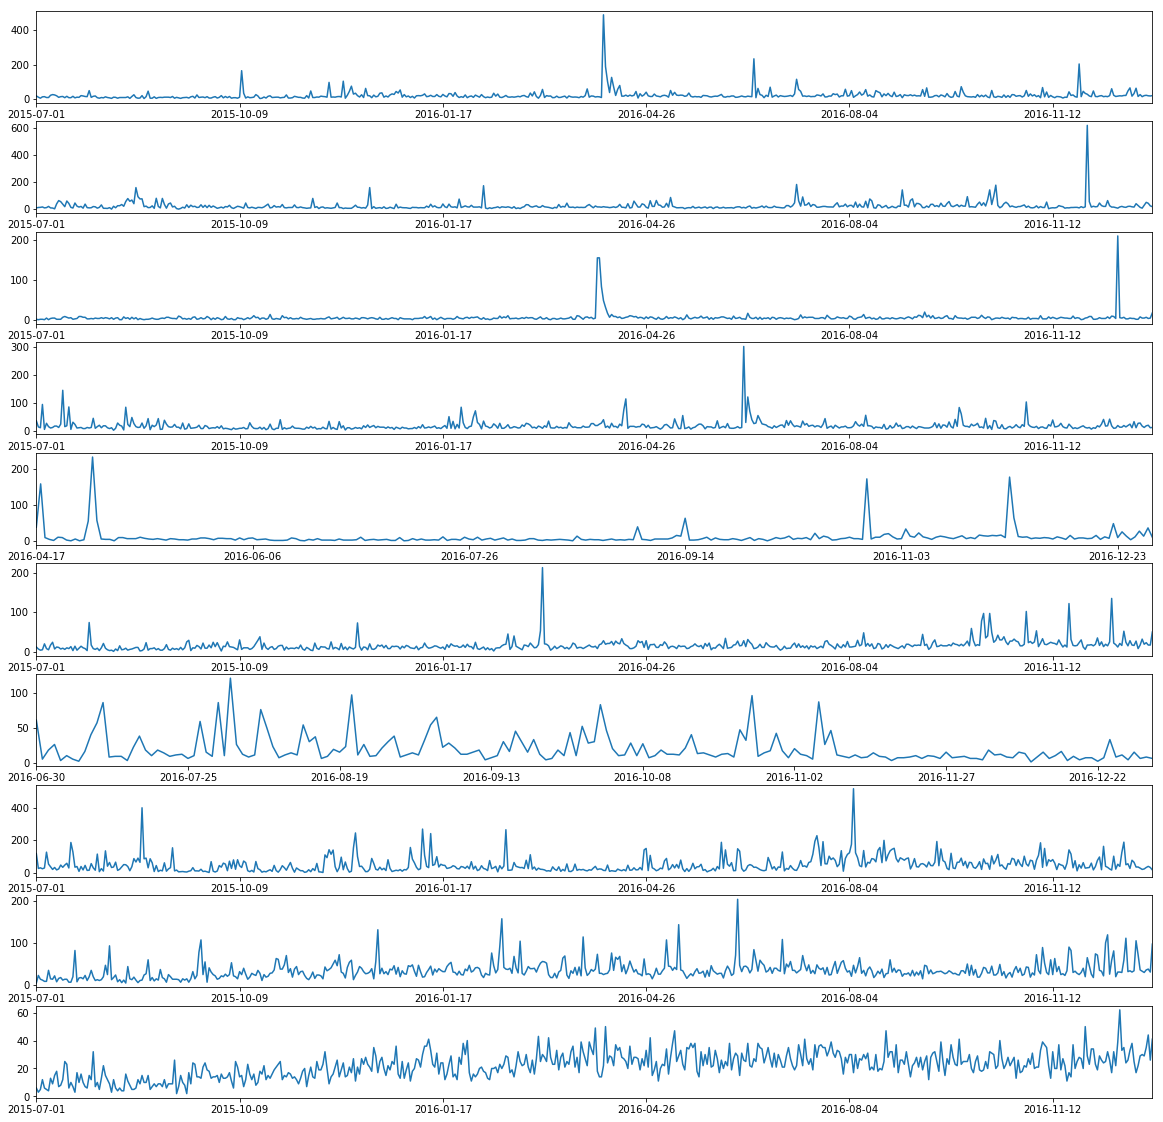

In [5]:
no_plots = 10
for i in range(0,no_plots):
    plt.subplot(no_plots,1,i+1)
    row = df.iloc[i][1:].dropna()
    row.plot(kind='line',figsize=(20,20))
plt.show()

In [26]:
rowdf = fromSeriesToDF(df,None,6).dropna()
rowdf.reset_index(inplace=True)
rowdf['ds'] = pd.to_datetime(rowdf['ds'])
rowdf = rowdf.set_index('ds')
row_good = rowdf.drop('index',axis=1)
s=sm.tsa.seasonal_decompose(row_good,freq=[1,2,3])
res = s.plot()
res.set_figheight(20)
res.set_figwidth(20)
plt.show()

ValueError: freq D not understood. Please report if you think this in error.

In [23]:
s.seasonal

NameError: name 's' is not defined